# RFM-сегментация клиентов

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import umap.umap_ as umap
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

### RFM-сегментация клиентов по CRISP-DM

### Анализ данных (Data Understanding)

#### Загрузка данных и структура таблицы

In [9]:
df = pd.read_csv('/content/sample_data/customer_segmentation_project.csv', encoding='ISO-8859-1')

print("Размер данных:", df.shape)

print("\nТипы данных и наличие non-null:")
df.info()

Размер данных: (541909, 8)

Типы данных и наличие non-null:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
df.rename(columns={
    'InvoiceDate': 'PurchaseDate',
    'UnitPrice': 'PricePerUnit',
    'Quantity': 'Qty',
    'CustomerID': 'ClientID'
}, inplace=True)

####Первичный обзор данных

In [11]:
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

print("\nДиапазон дат:", df['PurchaseDate'].min(), "до", df['PurchaseDate'].max())

print("Уникальных ClientID:", df['ClientID'].nunique())

print("Уникальных StockCode:", df['StockCode'].nunique())

print("Уникальных стран:", df['Country'].nunique())

print("\nTop-5 стран по числу транзакций:")
print(df['Country'].value_counts().head())


Диапазон дат: 2010-12-01 08:26:00 до 2011-12-09 12:50:00
Уникальных ClientID: 4372
Уникальных StockCode: 4070
Уникальных стран: 38

Top-5 стран по числу транзакций:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64




#### Обработка пропусков и дубликатов

In [12]:
# Исключаем полные дубликаты строк
# Исключаем записи с пропущенными значениями ClientID и Description

print("\nКоличество пропусков:")
print(df.isna().sum())

initial_rows = df.shape[0]
df = df.dropna(subset=['ClientID', 'Description'])
df = df.drop_duplicates()
print(f"\nУдалено строк: {initial_rows - df.shape[0]}")

print("Размер данных после очистки:", df.shape)


Количество пропусков:
InvoiceNo            0
StockCode            0
Description       1454
Qty                  0
PurchaseDate         0
PricePerUnit         0
ClientID        135080
Country              0
dtype: int64

Удалено строк: 140305
Размер данных после очистки: (401604, 8)


####Анализ выбросов и аномалий

In [13]:
print("\nСтатистика Qty и PricePerUnit:")
print(df[['Qty', 'PricePerUnit']].describe(percentiles=[0.01, 0.05, 0.95, 0.99]))


print("\nКоличество возвратов (Qty < 0):", (df['Qty'] < 0).sum())

print("Бесплатные товары (PricePerUnit = 0):", (df['PricePerUnit'] == 0).sum())


Статистика Qty и PricePerUnit:
                 Qty   PricePerUnit
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
1%         -2.000000       0.210000
5%          1.000000       0.420000
50%         5.000000       1.950000
95%        36.000000       8.500000
99%       120.000000      15.000000
max     80995.000000   38970.000000

Количество возвратов (Qty < 0): 8872
Бесплатные товары (PricePerUnit = 0): 40


### Подготовка данных (Data Preparation)

####Очистка: удаление пропусков и дубликатов

In [14]:
initial_rows = df.shape[0]
df = df[(df['Qty'] != 0) & (df['PricePerUnit'] != 0)]
print(f"\nУдалено строк с Qty=0 или PricePerUnit=0: {initial_rows - df.shape[0]}")

print("Оставшихся возвратов:", (df['Qty'] < 0).sum())


Удалено строк с Qty=0 или PricePerUnit=0: 40
Оставшихся возвратов: 8872


####Создание TotalPrice

In [15]:
# Рассчитываем новый столбец — общая сумма покупки по строке
df['LineTotal'] = df['PricePerUnit'] * df['Qty']

print("\nСредняя сумма по строке:", round(df['LineTotal'].mean(), 2))

print("Общая сумма транзакций:", round(df['LineTotal'].sum(), 2))


Средняя сумма по строке: 20.62
Общая сумма транзакций: 8278519.42


####Формирование RFM-признаков

In [16]:
# Группируем по клиентам и рассчитываем RFM
# Агрегируем данные по клиентам: RFM-признаки
# Рассчитываем новый столбец — общая сумма покупки по строке
reference_date = df['PurchaseDate'].max() + pd.Timedelta(days=1)

# Отделяем возвраты для Frequency
sales_df = df[~df['InvoiceNo'].str.startswith('C', na=False)]

# Группировка по клиентам
rfm = sales_df.groupby('ClientID').agg(
    Recency=('PurchaseDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique')
).reset_index()

# Рассчитываем Monetary (с учетом возвратов)
monetary = df.groupby('ClientID').agg(Monetary=('LineTotal', 'sum')).reset_index()
rfm = rfm.merge(monetary, on='ClientID', how='left').fillna(0)


print("\nПример RFM данных:")
print(rfm.head())


Пример RFM данных:
   ClientID  Recency  Frequency  Monetary
0   12346.0      326          1      0.00
1   12347.0        2          7   4310.00
2   12348.0       75          4   1797.24
3   12349.0       19          1   1757.55
4   12350.0      310          1    334.40


####Обработка выбросов

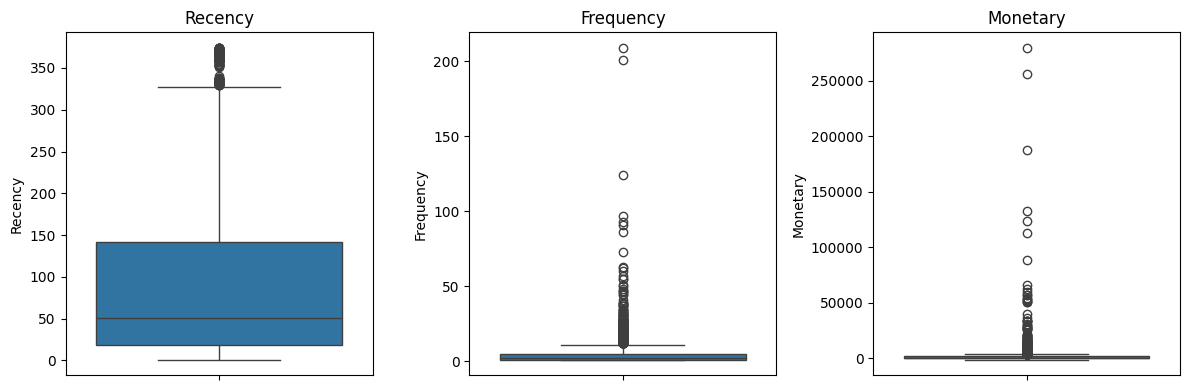


Удалено клиентов-выбросов: 68


In [17]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=rfm[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Фильтрация выбросов
rfm_filtered = rfm[
    (rfm['Frequency'] <= 30) &
    (rfm['Monetary'] <= 20000) &
    (rfm['Monetary'] >= 0)
].copy()
print(f"\nУдалено клиентов-выбросов: {len(rfm) - len(rfm_filtered)}")

# Стандартизация данных
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

### RFM-сегментация клиентов по CRISP-DM

### Кластеризация (Modeling)

#### Определение оптимального числа кластеров (K-Means)

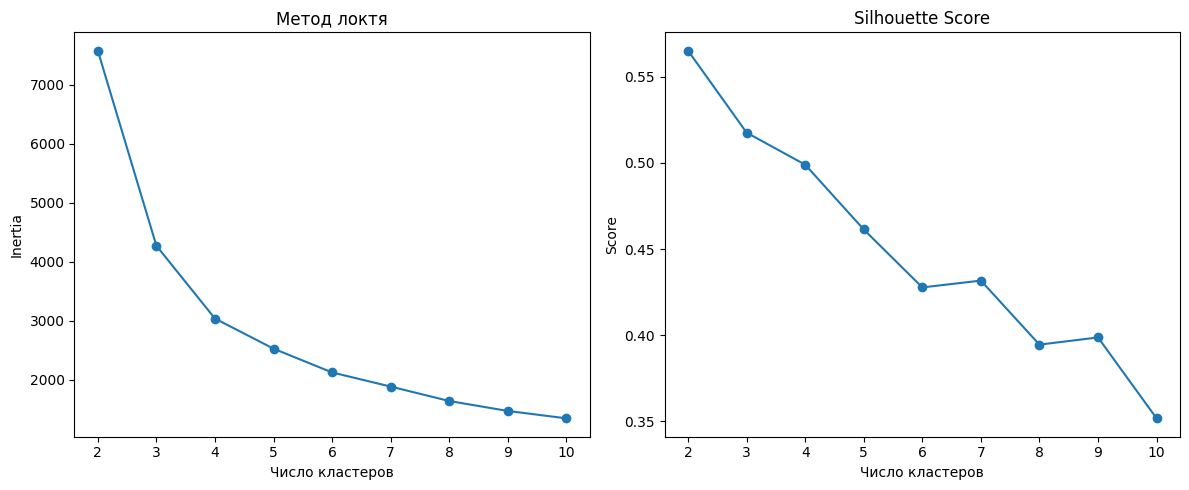

Оптимальное число кластеров: 2 (Silhouette: 0.565)


In [18]:
# Применяем алгоритм кластеризации модель K-Means для выбранного K
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(k_range, inertias, 'o-')
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')

plt.subplot(122)
plt.plot(k_range, sil_scores, 'o-')
plt.title('Silhouette Score')
plt.xlabel('Число кластеров')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# Выбор оптимального K
optimal_k = k_range[np.argmax(sil_scores)]
print(f"Оптимальное число кластеров: {optimal_k} (Silhouette: {max(sil_scores):.3f})")

#### Кластеризация K-Means

In [19]:
# Применяем алгоритм кластеризации модель K-Means для выбранного K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_filtered['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Распределение кластеров
cluster_dist = rfm_filtered['Cluster'].value_counts().sort_index()

print("\nРаспределение по кластерам:")
print(cluster_dist)


Распределение по кластерам:
Cluster
0    3733
1     537
Name: count, dtype: int64


#### Визуализация кластеров

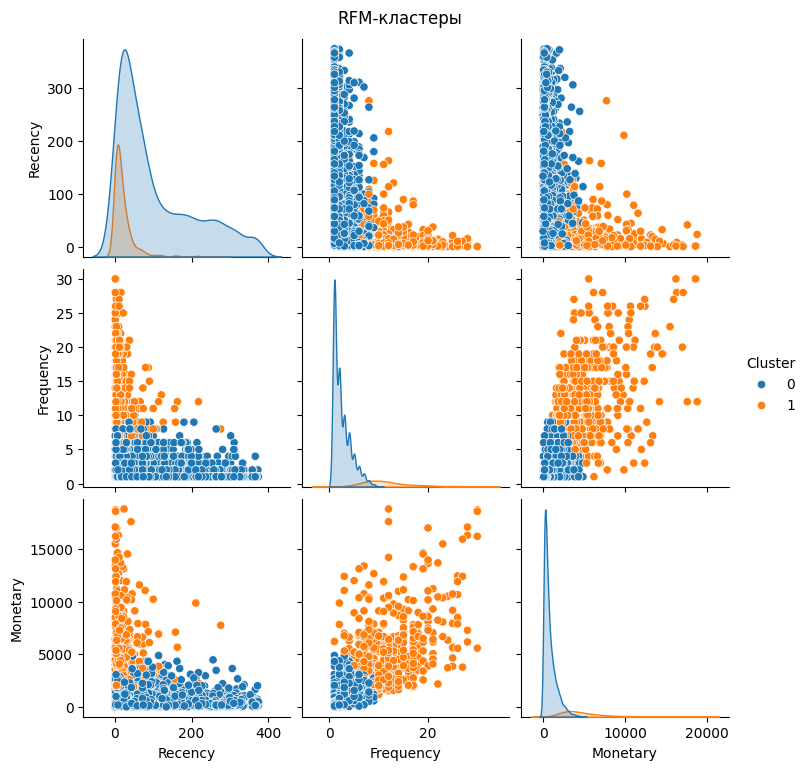

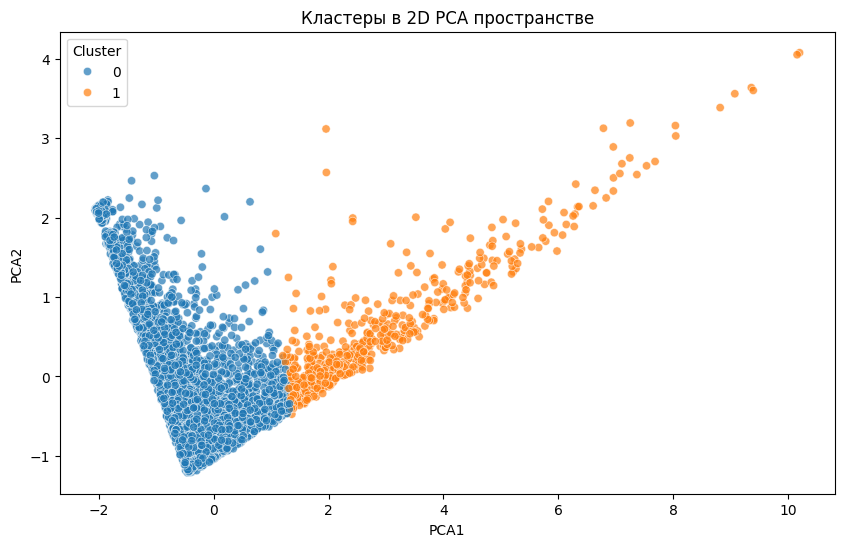

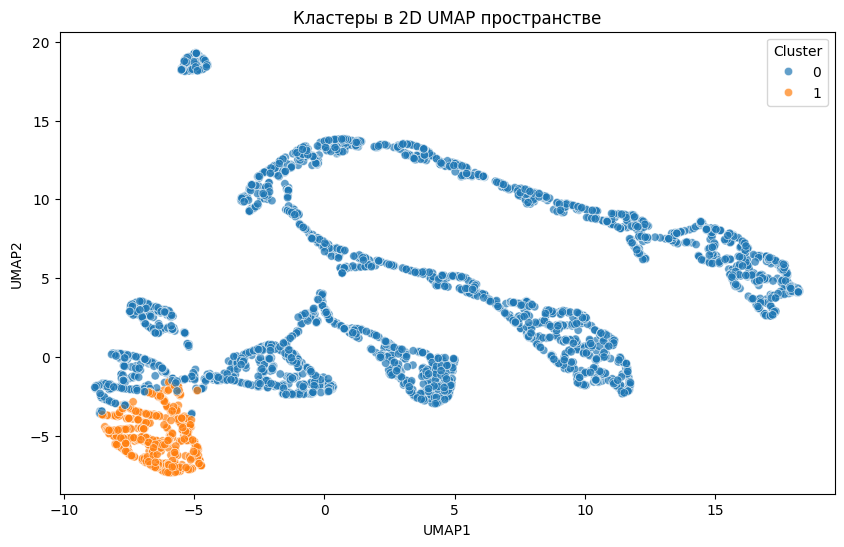

In [20]:
# Pairplot
sns.pairplot(rfm_filtered, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='tab10')
plt.suptitle('RFM-кластеры', y=1.02)
plt.show()

# PCA визуализация
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)
rfm_filtered['PCA1'] = pca_result[:, 0]
rfm_filtered['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_filtered, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', alpha=0.7)
plt.title('Кластеры в 2D PCA пространстве')
plt.show()

# UMAP визуализация
reducer = umap.UMAP(random_state=42)
umap_result = reducer.fit_transform(rfm_scaled)
rfm_filtered['UMAP1'] = umap_result[:, 0]
rfm_filtered['UMAP2'] = umap_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_filtered, x='UMAP1', y='UMAP2', hue='Cluster', palette='tab10', alpha=0.7)
plt.title('Кластеры в 2D UMAP пространстве')
plt.show()

### RFM-сегментация клиентов по CRISP-DM

#### Интерпретация и оценка результатов (Evaluation)

#### Характеристика сегментов по RFM


Средние значения по кластерам:
         Recency  Frequency  Monetary  Count
Cluster                                     
0          103.8        2.5     788.9   3733
1           20.3       12.0    5125.4    537


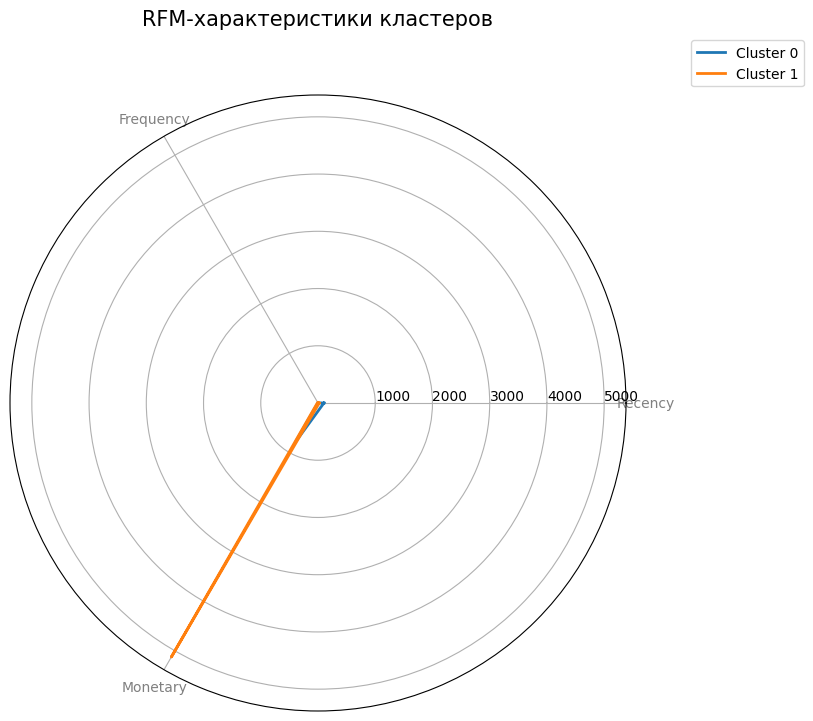

In [21]:
# Группируем по клиентам и рассчитываем RFM
cluster_means = rfm_filtered.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'ClientID': 'count'
}).rename(columns={'ClientID': 'Count'})


print("\nСредние значения по кластерам:")
print(cluster_means.round(1))

# Радарная диаграмма
def plot_radar_chart(cluster_summary, title):
    categories = list(cluster_summary.columns)[:-1]
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.set_rlabel_position(0)

    for idx, row in cluster_summary.iterrows():
        values = row[categories].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {idx}')
        ax.fill(angles, values, alpha=0.1)

    plt.title(title, size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

plot_radar_chart(cluster_means, "RFM-характеристики кластеров")

#### Качество кластеризации и соответствие бизнес-целям

In [24]:
cluster_names = {
    0: "VIP Клиенты",
    1: "Ушедшие Клиенты",
}

# Добавляем названия сегментов
rfm_filtered['Segment'] = rfm_filtered['Cluster'].map(cluster_names)

# Вывод рекомендаций по сегментам
print("\nРекомендации по сегментам:")
for cluster, name in cluster_names.items():
    segment_df = cluster_means.loc[cluster]
    print(f"\n--- {name} ---")
    print(f"Размер: {segment_df['Count']} клиентов ({segment_df['Count']/len(rfm_filtered)*100:.1f}%)")
    print(f"Recency: {segment_df['Recency']:.0f} дней")
    print(f"Frequency: {segment_df['Frequency']:.1f} покупок")
    print(f"Monetary: £{segment_df['Monetary']:.0f}")

    if "VIP" in name:
        print("Рекомендации: Персональный менеджер, эксклюзивные предложения, программа лояльности")
    elif "Ушедшие" in name:
        print("Рекомендации: Специальные акции для возврата, опросы о причинах ухода")



Рекомендации по сегментам:

--- VIP Клиенты ---
Размер: 3733.0 клиентов (87.4%)
Recency: 104 дней
Frequency: 2.5 покупок
Monetary: £789
Рекомендации: Персональный менеджер, эксклюзивные предложения, программа лояльности

--- Ушедшие Клиенты ---
Размер: 537.0 клиентов (12.6%)
Recency: 20 дней
Frequency: 12.0 покупок
Monetary: £5125
Рекомендации: Специальные акции для возврата, опросы о причинах ухода
